In [123]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import argparse
import numpy as np
from sklearn.metrics import normalized_mutual_info_score

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from tqdm import tqdm
import pickle
from torch import optim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
class Encoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(Encoder, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc1_bn=nn.BatchNorm1d(h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc2_bn=nn.BatchNorm1d(h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        
        self.x_dim = x_dim
        
    def encoder(self, x):
        h = F.relu(self.fc1_bn(self.fc1(x)))
        h = F.relu(self.fc2_bn(self.fc2(h)))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5*log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu) # return z sample
        else:
            return mu
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, self.x_dim))
        z = self.sampling(mu, log_var)
        return z, mu, log_var

class Decoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(Decoder, self).__init__()
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc4_bn =nn.BatchNorm1d(h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc5_bn =nn.BatchNorm1d(h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
        self.x_dim = x_dim
        
    def decoder(self, z):
        h = F.relu(self.fc4_bn(self.fc4(z)))
        h = F.relu(self.fc5_bn(self.fc5(h)))
        return F.tanh(self.fc6(h)) 
    
    def forward(self, z):
        return self.decoder(z)


In [4]:
from torchvision import transforms
from torchvision.utils import make_grid


In [5]:
from torch.utils.data import Dataset

class AttributeDataset(Dataset):
    def __init__(self, root, split, transform=None):
        super(AttributeDataset, self).__init__()
        data_path = os.path.join(root, split, "images.npy")
        self.data = np.load(data_path)
        
        attr_path = os.path.join(root, split, "attrs.npy")
        self.attr = torch.LongTensor(np.load(attr_path))

        attr_names_path = os.path.join(root, "attr_names.pkl")
        with open(attr_names_path, "rb") as f:
            self.attr_names = pickle.load(f)
        
        self.num_attrs =  self.attr.size(1)
#         self.set_query_attr_idx(query_attr_idx)
        self.transform = transform
    
#     def set_query_attr_idx(self, query_attr_idx):
#         if query_attr_idx is None:
#             query_attr_idx = torch.arange(self.num_attrs)
        
#         self.query_attr = self.attr[:, query_attr_idx]
        
    def __len__(self):
        return self.attr.size(0)

    def __getitem__(self, index):
        image, digit, color = self.data[index], self.attr[index, 0], self.attr[index, 1]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, digit, color

In [6]:
data_dir='./data/ColoredMNIST-Skewed0.3-Severity1'
split = 'train'

In [86]:
MEAN = torch.tensor([0.5,0.5,0.5])
STD = torch.tensor([0.5,0.5,0.5])

batch_size = 128

train_set = AttributeDataset(data_dir, split, transform=transforms.Compose([transforms.ToTensor(),
                                                                           transforms.Normalize(MEAN, STD)]))
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

test_set = AttributeDataset(data_dir, 'valid', transform=transforms.Compose([transforms.ToTensor(),
                                                                           transforms.Normalize(MEAN, STD)]))

import torch
seed = 2020
torch.manual_seed(seed) 
def worker_init_fn(worker_id):
    torch.manual_seed(seed + worker_id)
    
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=128, shuffle=True, worker_init_fn=worker_init_fn)

In [146]:
class Classifier(nn.Module):
    def __init__(self, input_dim = 64, hidden_dim = 16, output_dim = 2):
        super(Classifier, self).__init__()
        self.input_dim = input_dim 
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = self.dense2(x)
        
        return x
    def get_parameters(self):
        return [{"params": self.parameters(), "lr_mult": 1}]

In [9]:
from torch.autograd import Variable


In [10]:
def compute_density(z, mu, logvar, marginal = True):
    pi = Variable(torch.Tensor([np.log(2 * np.pi)])).type_as(z)
    inv_sigma = torch.exp(-logvar)
    tmp = (z - mu) * inv_sigma
    # return (-0.5 * (tmp * tmp + 2 * logvar + pi)).exp().prod(-1, keepdim = True)
    value = (-0.5 * (tmp * tmp + 2 * logvar + pi)).sum(-1).exp()
    
    if marginal:
        return value.mean(-1)
    else:
        return value
    
def expand_latent(x,y,z = None):
    if z is None:
        x_expand = x.unsqueeze(1).expand(-1, x.shape[0], -1)
        y_expand = y.unsqueeze(0).expand(x.shape[0], -1, -1)
        return x_expand, y_expand
    else:
        x_expand = x.unsqueeze(1).expand(-1, x.shape[0], -1)
        y_expand = y.unsqueeze(1).expand(-1, x.shape[0], -1)
        z_expand = z.unsqueeze(0).expand(x.shape[0], -1, -1)
        return x_expand, y_expand, z_expand

In [114]:
def CMI_loss(cls, z_y, z_r, s_batch, num_group = 10, beta=0.5):
    # updated 10/16/2023
    # updated H(Y|A,z_r) computation.
    z_y_repeat, z_r_repeat = expand_latent(z_y,z_r)

    z_yr = torch.cat([z_y_repeat, z_r_repeat], dim = -1).view(z_y.shape[0] **2, -1)

    p_y = torch.softmax(cls_y(z_yr).view(z_y.shape[0], z_y.shape[0], -1), -1)
    p_y_agg = p_y.mean(0)

    H_y_cond_z = -(p_y_agg * torch.log(p_y_agg + 1e-7)).sum(-1).mean()

    H_y_cond_za = 0.
    for idx in range(num_group): 
        s_idx = s_batch.view(-1) == idx

        p_y_zra = p_y[s_idx, :][:, s_idx, :].mean(0)
        H_y_cond_za += (- p_y_zra * torch.log(p_y_zra + 1e-7)).sum()
    H_y_cond_za /= s_batch.shape[0]  
    I_y_az = beta * H_y_cond_z - H_y_cond_za
    
#     assert I_y_az >= -1e-1, f"H_y_cond_z: {H_y_cond_z}, H_y_cond_za: {H_y_cond_za}"
    
    return I_y_az

In [115]:
def permute_zs(zs):
    B, _ = zs[0].size()
    perm_z = []
    
    for z_i in zs:
        perm = torch.randperm(B).cuda()
        perm_z.append(z_i[perm])
    return torch.cat(perm_z, 1)

## 1. Training FADES model

====> Epoch: 0, ELBO: 226.607, Fair Loss : 3.772, D_loss : 0.663, Y Loss: 0.143,  A Loss: 0.157


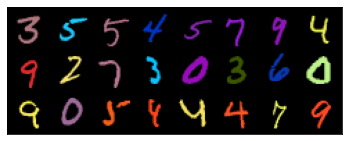

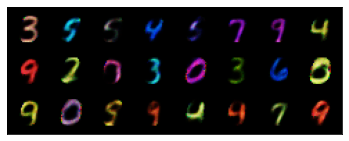

====> Epoch: 1, ELBO: 199.658, Fair Loss : 1.898, D_loss : 0.684, Y Loss: 0.095,  A Loss: 0.198
====> Epoch: 2, ELBO: 184.364, Fair Loss : 2.195, D_loss : 0.710, Y Loss: 0.053,  A Loss: 0.076
====> Epoch: 3, ELBO: 169.754, Fair Loss : 2.241, D_loss : 0.698, Y Loss: 0.060,  A Loss: 0.071
====> Epoch: 4, ELBO: 170.183, Fair Loss : 1.612, D_loss : 0.694, Y Loss: 0.046,  A Loss: 0.118
====> Epoch: 5, ELBO: 168.330, Fair Loss : 0.825, D_loss : 0.722, Y Loss: 0.025,  A Loss: 0.016
====> Epoch: 6, ELBO: 163.699, Fair Loss : 0.548, D_loss : 0.723, Y Loss: 0.019,  A Loss: 0.053
====> Epoch: 7, ELBO: 165.303, Fair Loss : 0.433, D_loss : 0.748, Y Loss: 0.021,  A Loss: 0.029
====> Epoch: 8, ELBO: 166.652, Fair Loss : 0.792, D_loss : 0.729, Y Loss: 0.049,  A Loss: 0.032
====> Epoch: 9, ELBO: 153.642, Fair Loss : 0.440, D_loss : 0.725, Y Loss: 0.010,  A Loss: 0.012
====> Epoch: 10, ELBO: 146.947, Fair Loss : 0.618, D_loss : 0.759, Y Loss: 0.017,  A Loss: 0.037


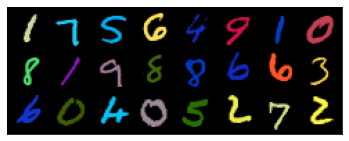

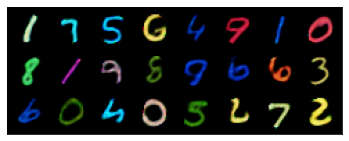

====> Epoch: 11, ELBO: 164.890, Fair Loss : 0.471, D_loss : 0.724, Y Loss: 0.030,  A Loss: 0.013
====> Epoch: 12, ELBO: 147.826, Fair Loss : 0.235, D_loss : 0.723, Y Loss: 0.022,  A Loss: 0.019
====> Epoch: 13, ELBO: 146.570, Fair Loss : 0.493, D_loss : 0.767, Y Loss: 0.032,  A Loss: 0.006
====> Epoch: 14, ELBO: 140.600, Fair Loss : 0.420, D_loss : 0.727, Y Loss: 0.011,  A Loss: 0.103
====> Epoch: 15, ELBO: 143.620, Fair Loss : -0.349, D_loss : 0.731, Y Loss: 0.007,  A Loss: 0.005
====> Epoch: 16, ELBO: 144.018, Fair Loss : -0.372, D_loss : 0.744, Y Loss: 0.026,  A Loss: 0.037
====> Epoch: 17, ELBO: 148.598, Fair Loss : 0.234, D_loss : 0.728, Y Loss: 0.009,  A Loss: 0.078
====> Epoch: 18, ELBO: 143.652, Fair Loss : -0.247, D_loss : 0.743, Y Loss: 0.016,  A Loss: 0.025
====> Epoch: 19, ELBO: 145.508, Fair Loss : -0.026, D_loss : 0.719, Y Loss: 0.039,  A Loss: 0.021
====> Epoch: 20, ELBO: 145.259, Fair Loss : -0.004, D_loss : 0.746, Y Loss: 0.011,  A Loss: 0.016


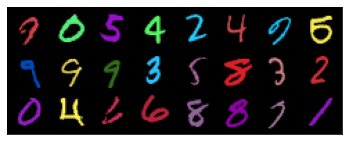

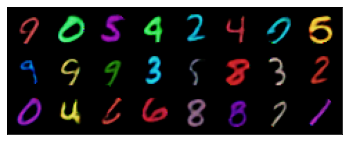

====> Epoch: 21, ELBO: 140.586, Fair Loss : 0.280, D_loss : 0.771, Y Loss: 0.009,  A Loss: 0.013
====> Epoch: 22, ELBO: 141.406, Fair Loss : 0.058, D_loss : 0.755, Y Loss: 0.009,  A Loss: 0.010
====> Epoch: 23, ELBO: 141.797, Fair Loss : 0.272, D_loss : 0.772, Y Loss: 0.018,  A Loss: 0.008
====> Epoch: 24, ELBO: 138.788, Fair Loss : -0.249, D_loss : 0.761, Y Loss: 0.003,  A Loss: 0.017
====> Epoch: 25, ELBO: 142.378, Fair Loss : -0.381, D_loss : 0.795, Y Loss: 0.030,  A Loss: 0.014
====> Epoch: 26, ELBO: 139.266, Fair Loss : -0.712, D_loss : 0.763, Y Loss: 0.009,  A Loss: 0.106
====> Epoch: 27, ELBO: 140.248, Fair Loss : -0.437, D_loss : 0.783, Y Loss: 0.010,  A Loss: 0.029
====> Epoch: 28, ELBO: 144.821, Fair Loss : 0.161, D_loss : 0.752, Y Loss: 0.004,  A Loss: 0.007
====> Epoch: 29, ELBO: 137.040, Fair Loss : -0.154, D_loss : 0.767, Y Loss: 0.003,  A Loss: 0.008
====> Epoch: 30, ELBO: 141.628, Fair Loss : -0.284, D_loss : 0.736, Y Loss: 0.003,  A Loss: 0.043


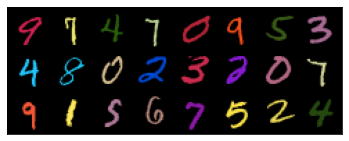

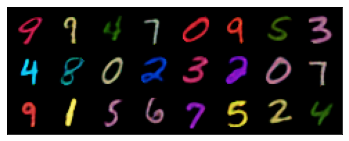

====> Epoch: 31, ELBO: 138.506, Fair Loss : -0.148, D_loss : 0.774, Y Loss: 0.051,  A Loss: 0.014
====> Epoch: 32, ELBO: 145.078, Fair Loss : -0.513, D_loss : 0.771, Y Loss: 0.011,  A Loss: 0.028
====> Epoch: 33, ELBO: 144.427, Fair Loss : -0.122, D_loss : 0.784, Y Loss: 0.005,  A Loss: 0.014
====> Epoch: 34, ELBO: 136.381, Fair Loss : -0.483, D_loss : 0.725, Y Loss: 0.009,  A Loss: 0.068
====> Epoch: 35, ELBO: 139.312, Fair Loss : -0.069, D_loss : 0.781, Y Loss: 0.054,  A Loss: 0.027
====> Epoch: 36, ELBO: 142.496, Fair Loss : -0.277, D_loss : 0.790, Y Loss: 0.022,  A Loss: 0.011
====> Epoch: 37, ELBO: 140.106, Fair Loss : -0.367, D_loss : 0.782, Y Loss: 0.005,  A Loss: 0.007
====> Epoch: 38, ELBO: 137.434, Fair Loss : -0.425, D_loss : 0.780, Y Loss: 0.001,  A Loss: 0.006
====> Epoch: 39, ELBO: 150.237, Fair Loss : -0.023, D_loss : 0.771, Y Loss: 0.016,  A Loss: 0.001
====> Epoch: 40, ELBO: 149.147, Fair Loss : -0.357, D_loss : 0.804, Y Loss: 0.008,  A Loss: 0.006


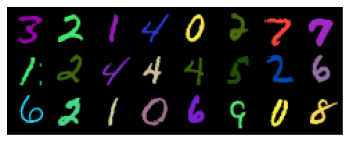

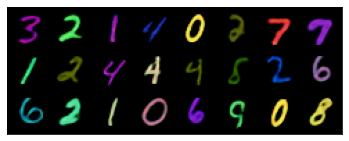

====> Epoch: 41, ELBO: 134.498, Fair Loss : -0.310, D_loss : 0.813, Y Loss: 0.009,  A Loss: 0.031
====> Epoch: 42, ELBO: 140.015, Fair Loss : -0.207, D_loss : 0.757, Y Loss: 0.001,  A Loss: 0.019
====> Epoch: 43, ELBO: 132.063, Fair Loss : -0.225, D_loss : 0.828, Y Loss: 0.002,  A Loss: 0.021
====> Epoch: 44, ELBO: 135.901, Fair Loss : -0.535, D_loss : 0.800, Y Loss: 0.003,  A Loss: 0.002
====> Epoch: 45, ELBO: 135.365, Fair Loss : -0.369, D_loss : 0.796, Y Loss: 0.006,  A Loss: 0.005
====> Epoch: 46, ELBO: 140.915, Fair Loss : -0.388, D_loss : 0.810, Y Loss: 0.026,  A Loss: 0.018
====> Epoch: 47, ELBO: 143.106, Fair Loss : -0.334, D_loss : 0.777, Y Loss: 0.003,  A Loss: 0.014
====> Epoch: 48, ELBO: 134.745, Fair Loss : -0.084, D_loss : 0.777, Y Loss: 0.001,  A Loss: 0.010
====> Epoch: 49, ELBO: 126.981, Fair Loss : -0.384, D_loss : 0.791, Y Loss: 0.003,  A Loss: 0.025
====> Epoch: 50, ELBO: 135.394, Fair Loss : -0.129, D_loss : 0.785, Y Loss: 0.002,  A Loss: 0.039


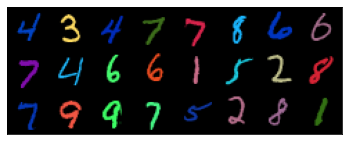

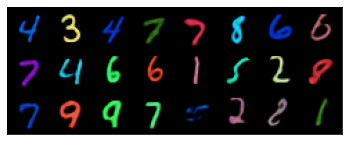

====> Epoch: 51, ELBO: 133.674, Fair Loss : -0.880, D_loss : 0.796, Y Loss: 0.013,  A Loss: 0.002
====> Epoch: 52, ELBO: 141.440, Fair Loss : -0.499, D_loss : 0.810, Y Loss: 0.004,  A Loss: 0.027
====> Epoch: 53, ELBO: 131.152, Fair Loss : -0.426, D_loss : 0.770, Y Loss: 0.003,  A Loss: 0.035
====> Epoch: 54, ELBO: 133.206, Fair Loss : -0.222, D_loss : 0.808, Y Loss: 0.024,  A Loss: 0.000
====> Epoch: 55, ELBO: 131.990, Fair Loss : -0.284, D_loss : 0.790, Y Loss: 0.016,  A Loss: 0.004
====> Epoch: 56, ELBO: 136.590, Fair Loss : -0.293, D_loss : 0.789, Y Loss: 0.009,  A Loss: 0.003
====> Epoch: 57, ELBO: 129.700, Fair Loss : -0.333, D_loss : 0.801, Y Loss: 0.001,  A Loss: 0.010
====> Epoch: 58, ELBO: 136.334, Fair Loss : -0.138, D_loss : 0.778, Y Loss: 0.026,  A Loss: 0.028
====> Epoch: 59, ELBO: 128.605, Fair Loss : -0.439, D_loss : 0.803, Y Loss: 0.003,  A Loss: 0.150
====> Epoch: 60, ELBO: 145.304, Fair Loss : -0.567, D_loss : 0.778, Y Loss: 0.005,  A Loss: 0.057


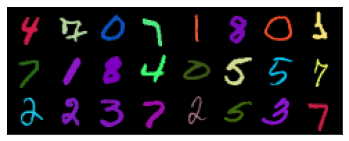

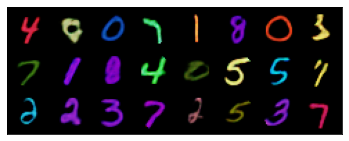

====> Epoch: 61, ELBO: 136.461, Fair Loss : -0.526, D_loss : 0.839, Y Loss: 0.005,  A Loss: 0.024
====> Epoch: 62, ELBO: 130.488, Fair Loss : -0.181, D_loss : 0.796, Y Loss: 0.025,  A Loss: 0.014
====> Epoch: 63, ELBO: 133.674, Fair Loss : -0.033, D_loss : 0.828, Y Loss: 0.034,  A Loss: 0.006
====> Epoch: 64, ELBO: 133.081, Fair Loss : -0.458, D_loss : 0.842, Y Loss: 0.003,  A Loss: 0.016
====> Epoch: 65, ELBO: 134.928, Fair Loss : 0.001, D_loss : 0.781, Y Loss: 0.001,  A Loss: 0.025
====> Epoch: 66, ELBO: 128.153, Fair Loss : -0.606, D_loss : 0.872, Y Loss: 0.038,  A Loss: 0.006
====> Epoch: 67, ELBO: 129.993, Fair Loss : -0.059, D_loss : 0.798, Y Loss: 0.011,  A Loss: 0.011
====> Epoch: 68, ELBO: 136.955, Fair Loss : -0.104, D_loss : 0.811, Y Loss: 0.018,  A Loss: 0.028
====> Epoch: 69, ELBO: 133.221, Fair Loss : -0.583, D_loss : 0.875, Y Loss: 0.019,  A Loss: 0.005
====> Epoch: 70, ELBO: 133.571, Fair Loss : -0.491, D_loss : 0.796, Y Loss: 0.012,  A Loss: 0.031


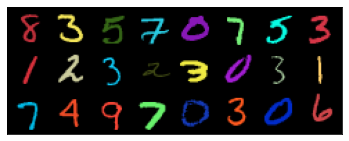

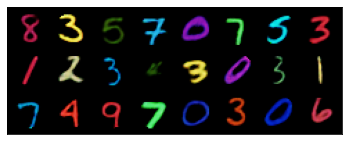

====> Epoch: 71, ELBO: 134.259, Fair Loss : -0.420, D_loss : 0.805, Y Loss: 0.005,  A Loss: 0.001
====> Epoch: 72, ELBO: 140.680, Fair Loss : -0.251, D_loss : 0.829, Y Loss: 0.019,  A Loss: 0.001
====> Epoch: 73, ELBO: 142.103, Fair Loss : 0.023, D_loss : 0.822, Y Loss: 0.001,  A Loss: 0.020
====> Epoch: 74, ELBO: 133.019, Fair Loss : -0.081, D_loss : 0.848, Y Loss: 0.016,  A Loss: 0.039
====> Epoch: 75, ELBO: 136.145, Fair Loss : -0.510, D_loss : 0.832, Y Loss: 0.049,  A Loss: 0.005
====> Epoch: 76, ELBO: 130.470, Fair Loss : -0.395, D_loss : 0.822, Y Loss: 0.015,  A Loss: 0.001
====> Epoch: 77, ELBO: 135.949, Fair Loss : -0.437, D_loss : 0.796, Y Loss: 0.004,  A Loss: 0.043
====> Epoch: 78, ELBO: 137.151, Fair Loss : -0.012, D_loss : 0.773, Y Loss: 0.002,  A Loss: 0.003
====> Epoch: 79, ELBO: 138.432, Fair Loss : -0.255, D_loss : 0.806, Y Loss: 0.003,  A Loss: 0.004
====> Epoch: 80, ELBO: 142.064, Fair Loss : -0.504, D_loss : 0.795, Y Loss: 0.003,  A Loss: 0.009


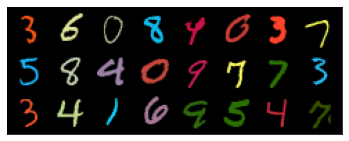

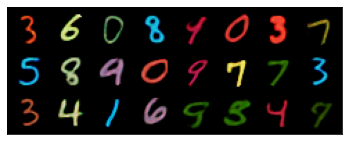

====> Epoch: 81, ELBO: 132.442, Fair Loss : -0.218, D_loss : 0.824, Y Loss: 0.003,  A Loss: 0.003
====> Epoch: 82, ELBO: 132.703, Fair Loss : -0.300, D_loss : 0.811, Y Loss: 0.007,  A Loss: 0.004
====> Epoch: 83, ELBO: 129.304, Fair Loss : -0.621, D_loss : 0.811, Y Loss: 0.017,  A Loss: 0.012
====> Epoch: 84, ELBO: 134.787, Fair Loss : -0.414, D_loss : 0.813, Y Loss: 0.001,  A Loss: 0.008
====> Epoch: 85, ELBO: 128.139, Fair Loss : -0.478, D_loss : 0.851, Y Loss: 0.002,  A Loss: 0.010
====> Epoch: 86, ELBO: 136.532, Fair Loss : -0.219, D_loss : 0.787, Y Loss: 0.026,  A Loss: 0.028
====> Epoch: 87, ELBO: 145.273, Fair Loss : -0.575, D_loss : 0.855, Y Loss: 0.001,  A Loss: 0.004
====> Epoch: 88, ELBO: 135.664, Fair Loss : -0.218, D_loss : 0.739, Y Loss: 0.024,  A Loss: 0.034
====> Epoch: 89, ELBO: 137.279, Fair Loss : -0.360, D_loss : 0.837, Y Loss: 0.003,  A Loss: 0.001
====> Epoch: 90, ELBO: 137.469, Fair Loss : -0.329, D_loss : 0.832, Y Loss: 0.004,  A Loss: 0.003


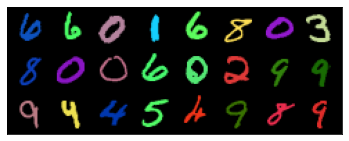

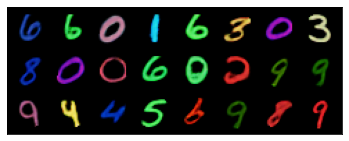

====> Epoch: 91, ELBO: 128.406, Fair Loss : -0.764, D_loss : 0.813, Y Loss: 0.019,  A Loss: 0.003
====> Epoch: 92, ELBO: 135.856, Fair Loss : -0.197, D_loss : 0.854, Y Loss: 0.002,  A Loss: 0.017
====> Epoch: 93, ELBO: 132.552, Fair Loss : -0.760, D_loss : 0.804, Y Loss: 0.022,  A Loss: 0.002
====> Epoch: 94, ELBO: 126.290, Fair Loss : -0.369, D_loss : 0.821, Y Loss: 0.005,  A Loss: 0.002
====> Epoch: 95, ELBO: 133.687, Fair Loss : -0.566, D_loss : 0.794, Y Loss: 0.002,  A Loss: 0.010
====> Epoch: 96, ELBO: 127.323, Fair Loss : -0.371, D_loss : 0.768, Y Loss: 0.008,  A Loss: 0.002
====> Epoch: 97, ELBO: 129.745, Fair Loss : -0.266, D_loss : 0.796, Y Loss: 0.002,  A Loss: 0.006
====> Epoch: 98, ELBO: 138.400, Fair Loss : -0.361, D_loss : 0.813, Y Loss: 0.008,  A Loss: 0.007
====> Epoch: 99, ELBO: 140.453, Fair Loss : -0.060, D_loss : 0.836, Y Loss: 0.004,  A Loss: 0.002
====> Epoch: 100, ELBO: 126.287, Fair Loss : -0.434, D_loss : 0.754, Y Loss: 0.003,  A Loss: 0.009


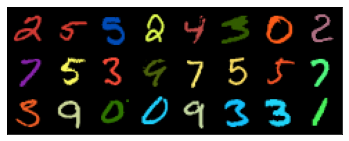

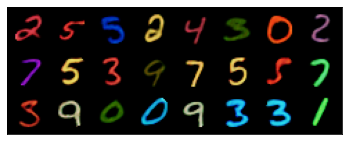

In [72]:
criterion = nn.CrossEntropyLoss()

cls_y = Classifier(input_dim = 8, output_dim = 10).cuda()
cls_a = Classifier(input_dim = 8, output_dim = 10).cuda()
dis = Classifier(input_dim = 12, output_dim = 1).cuda()

encoder = Encoder(x_dim=3*28*28, h_dim1= 256, h_dim2=256, z_dim=16).cuda()
decoder = Decoder(x_dim=3*28*28, h_dim1= 256, h_dim2=256, z_dim=16).cuda()

param_lst = list()
param_lst += list(encoder.parameters()) + list(decoder.parameters())
param_lst += list(cls_y.parameters()) + list(cls_a.parameters())         

optimizer = optim.Adam(param_lst, lr = 1e-3, weight_decay = 1e-5)
optimizer_d = optim.Adam(dis.parameters(), lr = 1e-4, weight_decay = 1e-5)

lambda_fair = 1e1
lambda_tc = 1e1

for epoch in range(100+1):
    train_loss = 0
    acc_y, acc_a, acc_y_pert = [], [], []
    train_iter = iter(train_loader_2)
    
    for batch_idx, (data, digit, color) in enumerate(train_loader):
        data = data.cuda()
        digit, color = digit.cuda(), color.cuda()

        optimizer.zero_grad()
        z, mu, log_var = encoder(data)
        z_y, z_r, z_a, z_x = z.split(4, dim = -1)
        mu_y, mu_r, mu_a, mu_x = mu.split(4, dim = -1)
        logvar_y, logvar_r, logvar_a, logvar_x = log_var.split(4, dim = -1)
        
        recon = decoder(z)

        MSE = F.l1_loss(recon, data.view(-1, 3*28*28), reduction = 'sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        ELBO = MSE + KLD
        ELBO /= len(data)

        pred_y = cls_y(torch.cat([z_y, z_r], dim =-1))
        pred_a = cls_a(torch.cat([z_a, z_r], dim =-1))

        loss_cls_y = criterion(pred_y, digit)
        loss_cls_a = criterion(pred_a, color)
        loss_cls = loss_cls_y + 0.5 * loss_cls_a 

        acc_a.append(pred_a.argmax(-1) == color)
        acc_y.append(pred_y.argmax(-1) == digit)

        loss = ELBO + 1e2 * loss_cls
        
        a_hat = pred_a.argmax(-1).detach()
        y_hat = pred_y.argmax(-1).detach()
        
        loss_fair = 0.5 * (CMI_loss(cls_y, z_y, z_r, color) + CMI_loss(cls_a, z_a, z_r, digit))
        loss_fair = lambda_fair * loss_fair
        loss += loss_fair
        
        
        ## Discriminator 
        pred_d = torch.sigmoid(dis(torch.cat([z_y, z_r, z_a],dim =1)))
        loss_D = -torch.log(pred_d+ 1e-7).mean()
        
        loss += lambda_tc * loss_D

        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()
        
        x_batch_2, _, _ = next(train_iter)
        x_batch_2 = x_batch_2.cuda().float()
        z_2, _, _ = encoder(x_batch_2)
        z_y_2, z_r_2, z_a_2, _ = z_2.split(4, dim = -1) # [z_x, z_y, z_r, z_a]

        pred_d_2_perm = permute_zs([z_y_2, z_r_2, z_a_2])
        pred_d_2 = torch.sigmoid(dis(pred_d_2_perm))

        z, mu, logvar = encoder(data)
        z_y, z_r, z_a, z_x = z.split(4, dim = -1)
        pred_d = torch.sigmoid(dis(torch.cat([z_y, z_r, z_a], dim =1)))

        D_tc_loss = 0.5 * (-torch.log(1-pred_d + 1e-7) \
                               - torch.log(pred_d_2 + 1e-7)).mean()

        optimizer_d.zero_grad()
        D_tc_loss.backward()
        optimizer_d.step()

    acc_a = torch.cat(acc_a, dim = 0).float().mean()
    acc_y = torch.cat(acc_y, dim = 0).float().mean()

    print('====> Epoch: {}, ELBO: {:.3f}, Fair Loss : {:.3f}, D_loss : {:.3f}, Y Loss: {:.3f},  A Loss: {:.3f}'\
                  .format(epoch, ELBO.item(), loss_fair.item(), loss_D.item(), loss_cls_y.item(), loss_cls_a.item() ))
    
    if epoch%10 == 0:
        with torch.no_grad():
            img, label, color = next(iter(test_loader))
            z, mu, var = encoder(img.cuda())
            recon = decoder(z)

            img = img[:24].cpu() * STD[:, None, None] + MEAN[:, None, None]
            fig = plt.imshow(make_grid(img, ncol=1).permute(1,2,0))
            plt.xticks([])
            plt.yticks([])
            plt.show()

            recon = recon.view(-1, 3, 28, 28)[:24].cpu() * STD[:, None, None] + MEAN[:, None, None]
            fig = plt.imshow(make_grid(recon, ncol=1).permute(1,2,0))
            plt.xticks([])
            plt.yticks([])
            plt.show()

## 2. Test Set t-SNE

In [73]:
latents_test = list()
labels_test = list()
colors_test = list()

encoder.eval()
with torch.no_grad():
    for img, label, color in test_loader:
        _, mu, var = encoder(img.cuda())
        latents_test.append(mu)
        labels_test.append(label)
        colors_test.append(color)

latents_test = torch.cat(latents_test, dim = 0)
labels_test = torch.cat(labels_test, dim = 0)
colors_test = torch.cat(colors_test, dim = 0)

In [74]:
tsne_test =  TSNE(n_components=2).fit_transform(latents_test.detach().cpu().numpy()[:, :8])

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/tmp/ipykernel_907118/3391979114.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c = labels_test.numpy(), s = 1, cmap=plt.cm.get_cmap("jet"))


([], [])

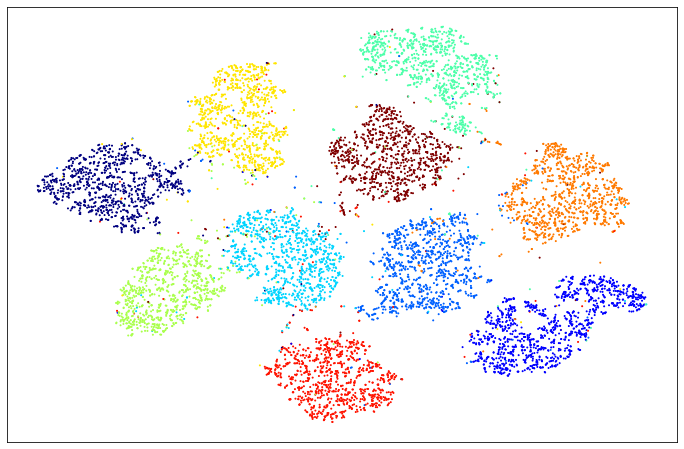

In [75]:
plt.figure(figsize = (12,8))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c = labels_test.numpy(), s = 1, cmap=plt.cm.get_cmap("jet"))
# plt1.set_color('k')
# plt2.set_color('k')
plt.xticks([])
plt.yticks([])
# plt.savefig('figure/motivation.pdf', ppi = 300, bbox_inches = 'tight')



/tmp/ipykernel_907118/1705890337.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c = colors_test.numpy(), s = 1, cmap=plt.cm.get_cmap("jet"))


([], [])

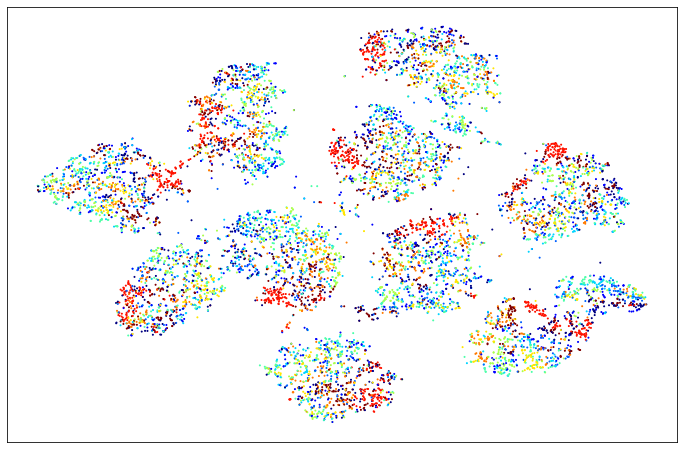

In [76]:
plt.figure(figsize = (12,8))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c = colors_test.numpy(), s = 1, cmap=plt.cm.get_cmap("jet"))
# plt1.set_color('k')
# plt2.set_color('k')
plt.xticks([])
plt.yticks([])
# plt.savefig('figure/motivation.pdf', ppi = 300, bbox_inches = 'tight')



## 3. Reconstruction

#### Load trained model

In [2]:
encoder = Encoder(x_dim=3*28*28, h_dim1= 256, h_dim2=256, z_dim=16).cuda()
decoder = Decoder(x_dim=3*28*28, h_dim1= 256, h_dim2=256, z_dim=16).cuda()
encoder.load_state_dict(torch.load('./save/c-mnist/CVPR24_encoder_fades.pth')['state_dict'])
decoder.load_state_dict(torch.load('./save/c-mnist/CVPR24_decoder_fades.pth')['state_dict'])

encoder.eval();
decoder.eval();

NameError: name 'Encoder' is not defined

In [ ]:
img_test, label_test, color_test = next(iter(test_loader))


In [ ]:
img = img_test[:24].cpu() * STD[:, None, None] + MEAN[:, None, None]
plt.imshow(make_grid(img, ncol=1).permute(1,2,0))
plt.xticks([])
plt.yticks([])
# plt.savefig('figure/c-mnist/original.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
z, mu, _ = encoder(img_test.cuda())
recon = decoder(mu)

with torch.no_grad():
    recon = recon.view(-1, 3, 28, 28)[:24].cpu() * STD[:, None, None] + MEAN[:, None, None]
    plt.imshow(make_grid(recon, ncol=1).permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
#     plt.show()
#     plt.savefig('figure/c-mnist/recon_fades.pdf', bbox_inches = 'tight')


## 4. Qualitative measure in Table 2

#### Oracle classifiers

Load orcale classifiers to quantitatively measure the quality of reconstruction.

In [144]:
class Classifier_oracle(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, n_class):
        super(Classifier, self).__init__()
        self.x_dim = x_dim
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc1_bn=nn.BatchNorm1d(h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc2_bn=nn.BatchNorm1d(h_dim2)
        self.fc3 = nn.Linear(h_dim2, n_class)
        
    def forward(self, x):
        h = F.relu(self.fc1_bn(self.fc1(x.view(-1, self.x_dim))))
        h = F.relu(self.fc2_bn(self.fc2(h)))
        return self.fc3(h)


In [141]:
cls_ocl_y = Classifier_oracle(x_dim=3*28*28, h_dim1= 256, h_dim2=256, n_class=10).cuda()
cls_ocl_a = Classifier_oracle(x_dim=3*28*28, h_dim1= 256, h_dim2=256, n_class=10).cuda()

cls_ocl_y.load_state_dict(torch.load('save/c-mnist/cls_digit.pth')['state_dict'])
cls_ocl_a.load_state_dict(torch.load('save/c-mnist/cls_color.pth')['state_dict'])


<All keys matched successfully>

In [142]:
with torch.no_grad():
    pred_y_lst, pred_a_lst, y_lst, a_lst = [], [], [], []

    for img, label, color in test_loader:
        z, _, _ = encoder(img.cuda())
        img = decoder(z)
        pred_y = cls_ocl_y(img)
        pred_a = cls_ocl_a(img)


        y_lst.append(label.detach())
        a_lst.append(color.detach())
        pred_y_lst.append(pred_y.argmax(-1).detach().cpu())
        pred_a_lst.append(pred_a.argmax(-1).detach().cpu())

    y_lst = torch.cat(y_lst, dim = 0)
    a_lst = torch.cat(a_lst, dim = 0)
    pred_y_lst = torch.cat(pred_y_lst, dim = 0)
    pred_a_lst = torch.cat(pred_a_lst, dim = 0)

In [143]:
print((pred_y_lst == y_lst).float().mean())
print((pred_a_lst == a_lst).float().mean())

tensor(0.9634)
tensor(0.9805)
